In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
import deepmatcher as dm
import pandas as pd
from utils.intermediate_layer_extraction import return_layer_input
from utils.dataset_parser import get_pos_neg_datasets,generate_train_valid_test
from utils.ri_calculator import computeRi
from utils.distance_measures import nearestNeighborOnAttributes,smallestDistanceOnAttributes

In [3]:
train_df,validation_df,test_df = generate_train_valid_test('../datasets/Cora',['cora.csv','cora.csv'],
                                                          ['cora_train.csv','cora_validation.csv','cora_test.csv'],
                                                          'left_','right_')

In [4]:
train_df.to_csv('../datasets/Cora/merged_train.csv',index=False)
validation_df.to_csv('../datasets/Cora/merged_validation.csv',index=False)
test_df.to_csv('../datasets/Cora/merged_test.csv',index=False)

In [5]:
train,validation,test = dm.data.process('../datasets/Cora/',train='merged_train.csv',
                                        validation='merged_validation.csv',test='merged_test.csv'
                                       ,ignore_columns=['left_id','right_id','left_cluster_name',
                                                       'right_cluster_name'])

[nltk_data] Error loading perluniprops: <urlopen error [Errno -2] Name
[nltk_data]     or service not known>
[nltk_data] Error loading nonbreaking_prefixes: <urlopen error [Errno
[nltk_data]     -2] Name or service not known>
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>

Reading and processing data from "../datasets/Cora/merged_train.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "../datasets/Cora/merged_validation.csv"
0% [############################# ] 100% | ETA: 00:00:00
Reading and processing data from "../datasets/Cora/merged_test.csv"
0% [############################# ] 100% | ETA: 00:00:00
Building vocabulary
0% [####] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00

Computing principal components
0% [####] 100% | ETA: 00:00:00
Total time elapsed: 00:00:04


In [6]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../models/cora_rnn.pth')
model = model.to('cuda')

In [12]:
testpos_df,testneg_df = get_pos_neg_datasets([test_df])
testpos_df = testpos_df.sample(frac=0.3)
##testneg_df = testneg_df.sample(frac=0.3)
testpos_df.to_csv('../datasets/Cora/test_positives_sample.csv',index=False)
##testneg_df.to_csv('../datasets/Cora/test_negatives_sample.csv',index=False)

In [13]:
testpos = return_layer_input(model,model.classifier,'../datasets/Cora','test_positives_sample',
                            ignore_columns=['label','left_id','right_id','left_cluster_name',
                                           'right_cluster_name'])


Reading and processing data from "../datasets/Cora/test_positives_sample.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [9]:
testneg = return_layer_input(model,model.classifier,'../datasets/Cora','test_negatives_sample',
                            ignore_columns=['label','left_id','right_id','left_cluster_name',
                                           'right_cluster_name'])


Reading and processing data from "../datasets/Cora/test_negatives_sample.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [10]:
cora_data = pd.read_csv('../datasets/Cora/cora.csv')
attributes = [col for col in cora_data.columns if col not in ['id','cluster_name']]
testneg_ri,testneg_ri_norms = computeRi(model.classifier,attributes,testneg,0)

100%|██████████| 713/713 [12:27<00:00,  1.05s/it]


In [14]:
testpos_ri,testpos_ri_norms = computeRi(model.classifier,attributes,testpos,1)


 46%|████▌     | 156/338 [02:53<02:32,  1.19it/s]


 93%|█████████▎| 313/338 [05:37<00:25,  1.02s/it]


100%|██████████| 338/338 [06:00<00:00,  1.07s/it]


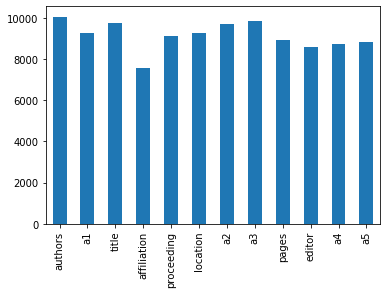

In [16]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar()

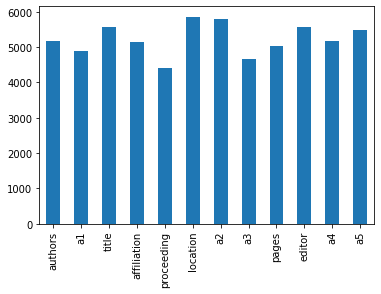

In [17]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar()

In [19]:
import torch
torch.save(testpos_ri,'cora_testpos_ri.pth')
torch.save(testneg_ri,'cora_testneg_ri.pth')

In [21]:
testpos_ri_norms.to_csv('cora_testpos_ri_norms.csv',index=False)
testneg_ri_norms.to_csv('cora_testneg_ri_norms.csv',index=False)